In [1]:
import time
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import Normalize
from PIL import Image


from pc import PS
from modules import ADC,DAC,CHIP
from cimCommand import CMD,CmdData,Packet
from cimCommand.singleCmdInfo import *

from util import plot_v_cond

In [2]:
chip=CHIP(PS(host="192.168.1.10", port = 7, debug=0),init=True)
chip.set_device_cfg(deviceType=0)

Connected to 192.168.1.10:7
local ip: 192.168.1.15 local port: 55412


In [3]:
fig_num = 0
def plot_cond(data,vmin = 0,vmax = 1400,title = ""):
    cmap = plt.cm.viridis
    norm = Normalize(vmin=vmin, vmax=vmax)
    im = plt.imshow(data, cmap=cmap,norm=norm)
    cbar = plt.colorbar(im)
    cbar.set_label("us")
    plt.title(title)
    global fig_num
    plt.savefig(f"./temp/{fig_num}.png")  # 保存为 PNG 格式
    fig_num = fig_num +1
    plt.show()

In [4]:
def write_verify(write_time,img_cond_lower,img_cond_upper,tg_v):
    vmin = np.min(img_cond_lower)
    vmax = np.max(img_cond_upper)
    need_read = np.ones((256,256),dtype=bool)
    voltage_base = np.zeros((256,256))
    voltage = np.zeros((256,256))
    cond_sub_base = None
    for i in range(write_time):
        print(f"第{i}次写验证")
        voltage_base[need_read] = chip.read_point2(crossbar=need_read, read_voltage=0,tg=5,gain=1,from_row=True,out_type=0)[need_read]
        voltage[need_read] = chip.read_point2(crossbar=need_read, read_voltage=0.1,tg=5,gain=1,from_row=True,out_type=0)[need_read]
        cond_sub_base = chip.voltage_to_cond(voltage-voltage_base)

        condition_reset = (cond_sub_base > img_cond_upper) & need_read
        condition_set = (cond_sub_base < img_cond_lower) & need_read
        need_read = condition_reset | condition_set

        plot_cond(cond_sub_base,vmin,vmax,title=f"{i},need_reset={int(np.sum(condition_reset))},need_set={int(np.sum(condition_set))}")
        
        if i>0:
            tg_v[condition_reset] -= 0.025
            tg_v[condition_set] += 0.025
        # reset的点
        chip.write_point2(crossbar=condition_reset,write_voltage=2,tg=5,pulse_width=1e-3,set_device=False)
        # set刚刚reset过的点
        
        chip.write_point2(crossbar=condition_reset,write_voltage=3,tg=tg_v,pulse_width=1e-3,set_device=True)
        chip.write_point2(crossbar=condition_set,write_voltage=3,tg=tg_v,pulse_width=1e-3,set_device=True)
        
    voltage_base[need_read] = chip.read_point2(crossbar=need_read, read_voltage=0,tg=5,gain=1,from_row=True,out_type=0)[need_read]
    voltage[need_read] = chip.read_point2(crossbar=need_read, read_voltage=0.1,tg=5,gain=1,from_row=True,out_type=0)[need_read]
    cond_sub_base = chip.voltage_to_cond(voltage-voltage_base)
    plot_cond(cond_sub_base,vmin,vmax,title=f"{write_time},need_reset={int(np.sum(condition_reset))},need_set={int(np.sum(condition_set))}")
    return cond_sub_base

### 1. 处理图片

(256, 256)


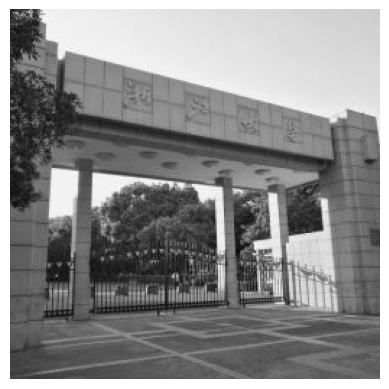

In [5]:
image_path = "./images/yuquan.jpg"
image = Image.open(image_path)

gray_image = image.convert("L")
width, height = gray_image.size
left = (width - 256) / 2
top = (height - 256) / 2
right = (width + 256) / 2
bottom = (height + 256) / 2

if width < 256 or height < 256:
    resized_image = gray_image.resize((256, 256))
else:
    cropped_image = gray_image.crop((left, top, right, bottom))
    resized_image = cropped_image.resize((256, 256))

resized_image = np.array(resized_image)
print(resized_image.shape)
plt.imshow(resized_image, cmap='gray')
plt.axis('off')
plt.show()

### 2.拟合tg和cond的线性映射

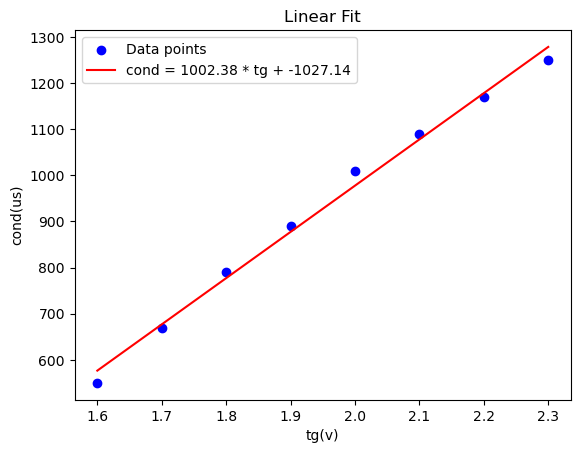

In [6]:
tg_map = [1.6,1.7,1.8,1.9,2.0,2.1,2.2,2.3]
cond_map = [550,670,790,890,1010,1090,1170,1250]

tg_map = np.array(tg_map)
cond_map = np.array(cond_map)

coefficients = np.polyfit(tg_map, cond_map, 1)  # 返回斜率和截距
slope = coefficients[0]
intercept = coefficients[1]

y_fit = slope * tg_map + intercept

plt.scatter(tg_map, cond_map, color='blue', label='Data points')  # 原始数据点
plt.plot(tg_map, y_fit, color='red', label=f'cond = {slope:.2f} * tg + {intercept:.2f}')  # 拟合直线
plt.xlabel('tg(v)')
plt.ylabel('cond(us)')
plt.legend()
plt.title('Linear Fit')
plt.show()

### 3.直接写对应值

582.1699346405225 1267.3267973856205
1.6054901960784314 2.289019607843137
664.4836601307186 714.4836601307186


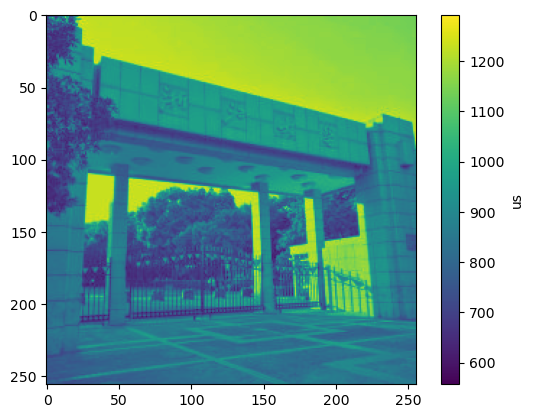

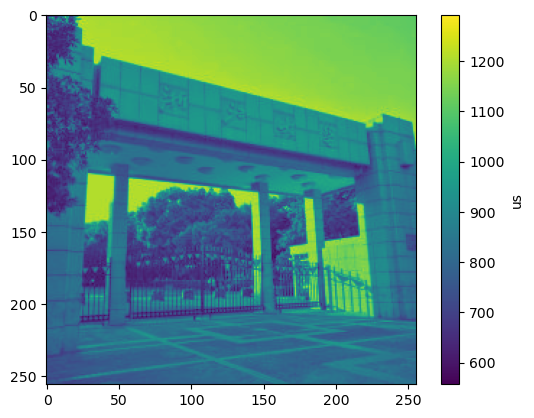

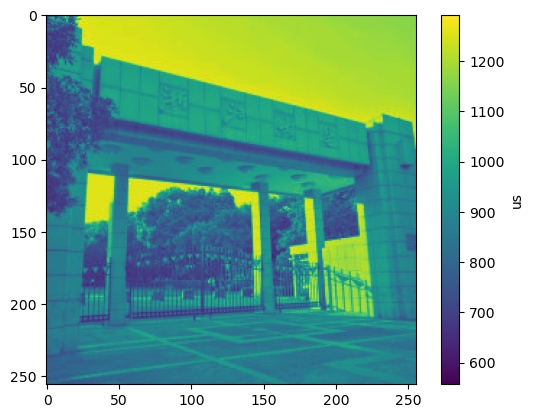

In [7]:
cond_min = slope * 1.6 + intercept
cond_max = slope * 2.3 + intercept

cond_target = cond_min + resized_image / 255 * (cond_max - cond_min)
cond_upper = cond_target + 25
cond_lower = cond_target - 25

img_tg = (cond_target - intercept)/slope
print(np.min(cond_target),np.max(cond_target),)
print(np.min(img_tg),np.max(img_tg),)

print(cond_lower[0,0],cond_upper[0,0])

plot_cond(cond_target,np.min(cond_lower),np.max(cond_upper))
plot_cond(cond_lower,np.min(cond_lower),np.max(cond_upper))
plot_cond(cond_upper,np.min(cond_lower),np.max(cond_upper))

第0次写验证
需要读65536个点
需要读65536个点


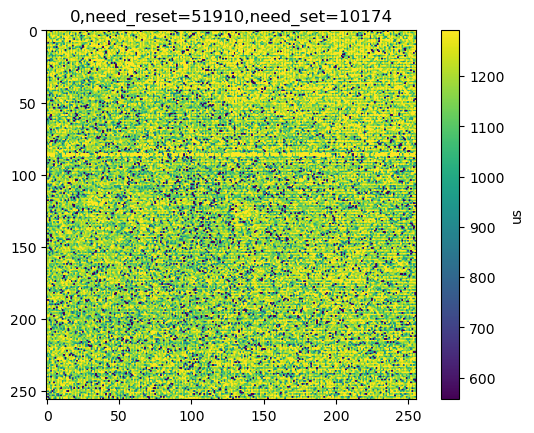

需要写51910个点
需要写51910个点
需要写10174个点
需要读62084个点
需要读62084个点


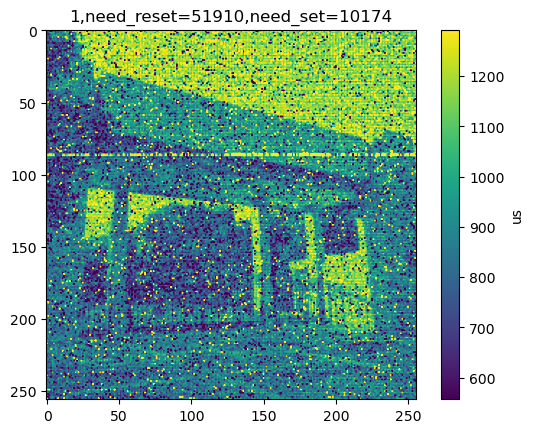

In [8]:
img_tg = (cond_target - intercept)/slope
cond_sub_base = write_verify(write_time=1,img_cond_lower=cond_lower,img_cond_upper=cond_upper,tg_v=img_tg)

In [67]:
need_read = np.ones((256,256))
voltage_base = chip.read_point2(crossbar=need_read, read_voltage=0,tg=5,gain=1,from_row=True,out_type=0)
voltage = chip.read_point2(crossbar=need_read, read_voltage=0.1,tg=5,gain=1,from_row=True,out_type=0)
cond_sub_base1 = chip.voltage_to_cond(voltage-voltage_base)

需要读65536个点
需要读65536个点


0 8318.0


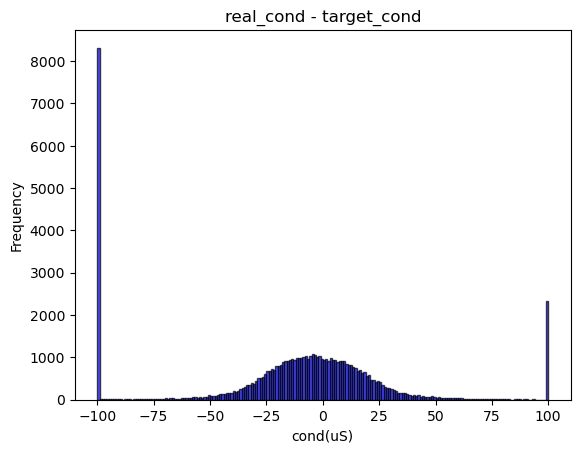

In [ ]:
cond_sub_base1 = np.load("result/error/cond_sub_base1.npy")
upper_bound = 100
lower_bound = -upper_bound
interval = 1
bin_edges = np.linspace(lower_bound, upper_bound, int((upper_bound-lower_bound)/interval)+1)
data = (cond_sub_base1-cond_target).flatten()
data[data<lower_bound]=lower_bound
data[data>upper_bound]=upper_bound
counts, bin_edges, _ = plt.hist(data, bins=bin_edges, color='blue', alpha=0.7, edgecolor='black')
np.save(f"result/error/cond_sub_base1.npy", cond_sub_base1)
max_count = np.max(counts)
max_index = np.argmax(counts)
print(max_index,max_count)
# 添加标题和标签
plt.title(f"real_cond - target_cond")
plt.xlabel("cond(uS)")
plt.ylabel("Frequency")

plt.savefig(f"result/error/interval{interval}_{int(max_index)*interval}us_{int(max_index+1)*interval}us.png")  # 保存为 PNG 格式
plt.show()

### 4. 划分8个态写对应值

7.0
576.6666666666663 1278.3333333333328
1.6 2.3
639.4836601307186 739.4836601307186


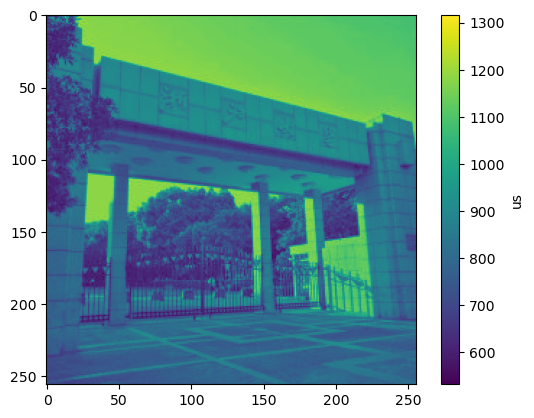

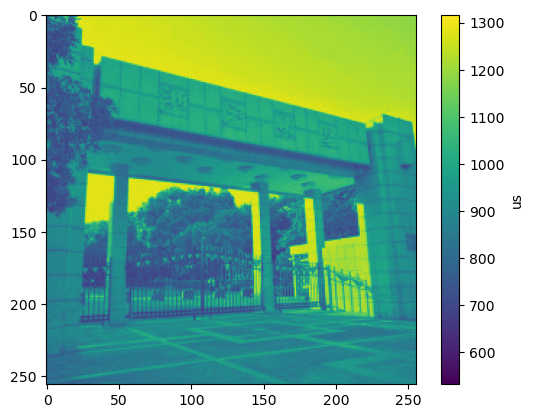

In [31]:
state_num = 8
img = np.floor(resized_image/(256/8))
print(np.max(img))
cond_min = slope * 1.6 + intercept
cond_max = slope * 2.3 + intercept

interval = (cond_max-cond_min)/(state_num-1)
cond_target = img*interval+cond_min
img_cond_lower = cond_target - interval/2
img_cond_upper = cond_target + interval/2


img_tg = (cond_target - intercept)/slope
print(np.min(cond_target),np.max(cond_target),)
print(np.min(img_tg),np.max(img_tg),)
print(cond_lower[0,0],cond_upper[0,0])

plot_cond(cond_lower,np.min(cond_lower),np.max(cond_upper))
plot_cond(cond_upper,np.min(cond_lower),np.max(cond_upper))